This script is for the statistical data analysis for the article "Classification and biomarker identification of prostate tissue from TRAMP mice with hyperpolarized 13C-SIRA" by A. Frahm et al. Talanta. 2021 Aug 20:122812.

All code is written by A Frahm (annetirsdag@gmail.com).

Versions used:

Python: 3.6.10 Scipy: 1.5.2 sklearn: 0.23.2

In [1]:
%run "Code for Frahm et al. 2021 - Functions.ipynb"

Read in data an meta-data

In [2]:
data_in = pickle.load(open("data_noesy_final.p", "rb"))
md = pd.read_excel("md_final.xlsx", index_col= 0)

Cut ppm values above 10 from the data

In [3]:
data = data_in.drop(data_in.columns[data_in.columns.values >= 9.99], axis = 1)

There are 496 bins in total


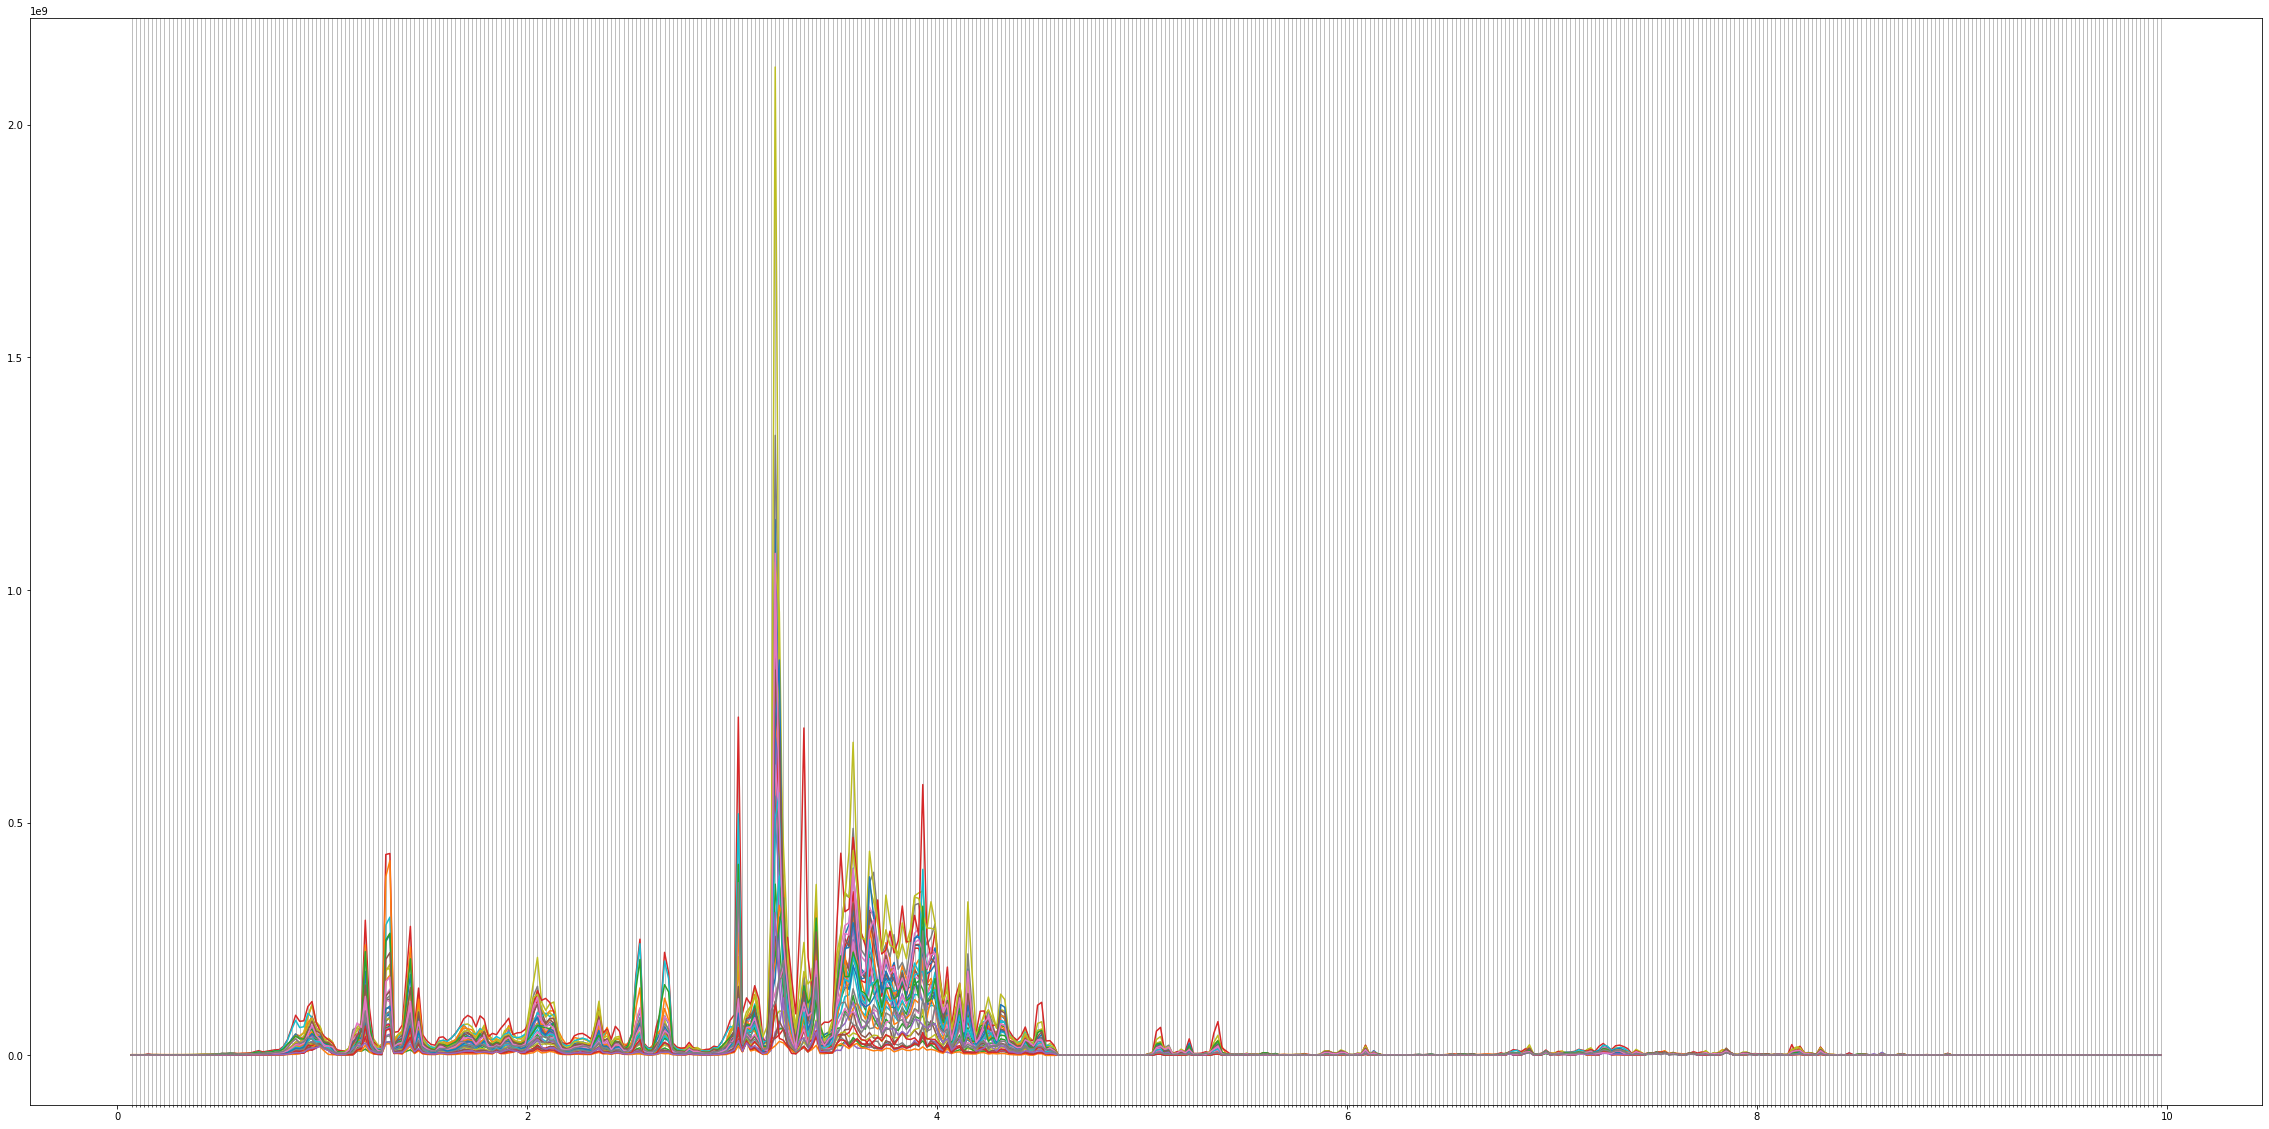

In [4]:
ref_loc = np.array([-0.06, 0.05]) #ppms of reference

#find data coulmns of ref.
ref_ppms = data.columns[(data.columns < max(ref_loc)) & (data.columns > min(ref_loc))]

data_u_ref = data.drop(ref_ppms, axis=1) 

#make binned data without ref
binned_data = bin_data(data_u_ref)

#get integrals of the ref peak.
ref = data[ref_ppms].sum(axis=1)

Noise filtering

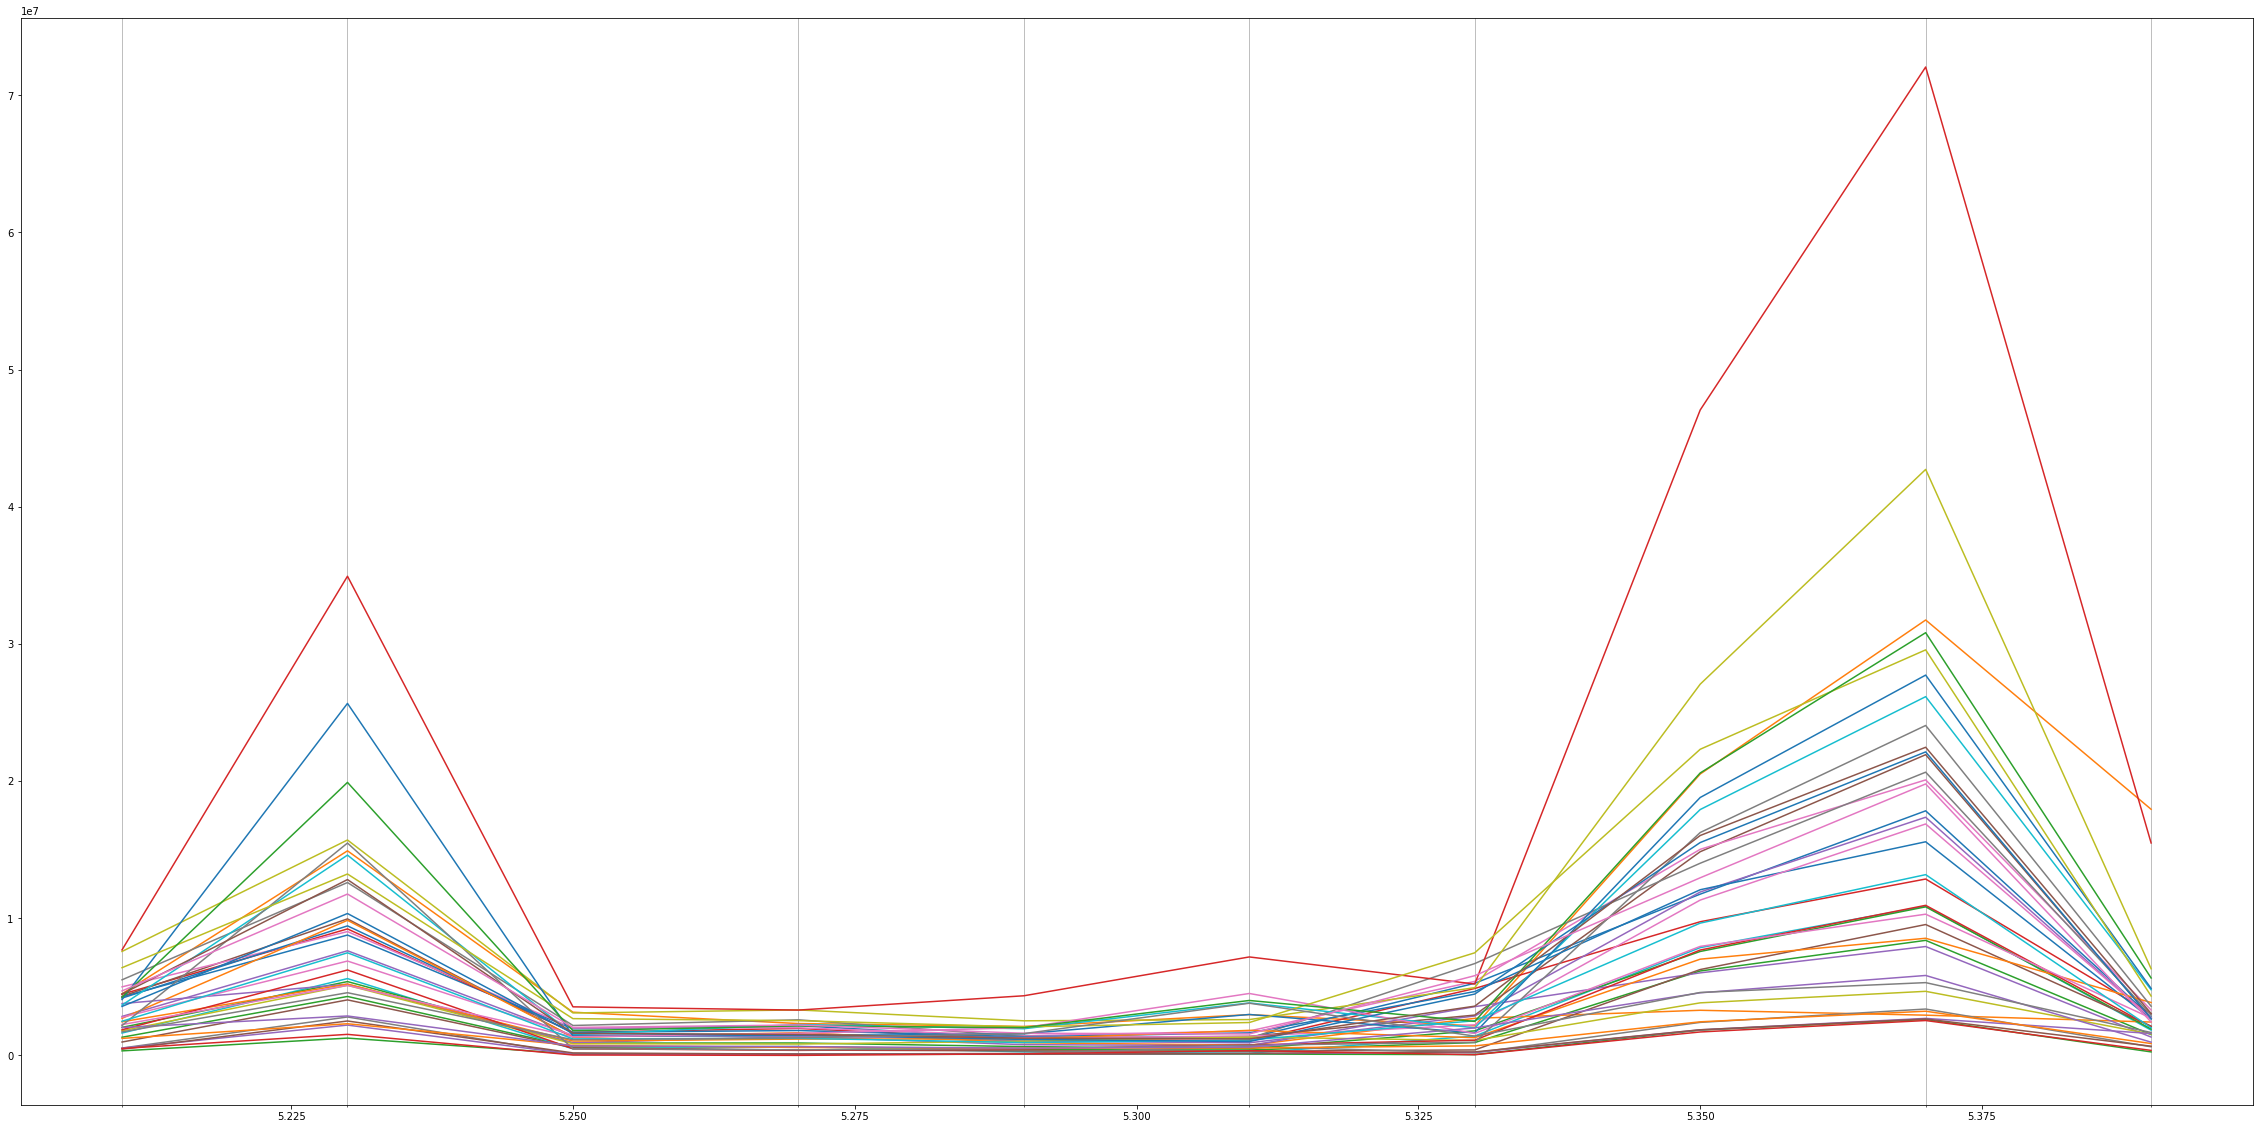

In [5]:
#choose spectral region with a high noise level
reg_noise = binned_data.columns[(binned_data.columns > 5.2) & (binned_data.columns < 5.4)]

#plot region
plt.rcParams['figure.figsize'] = [40, 20]
ax = binned_data[reg_noise].T.plot(legend= None)
xtick = reg_noise
ax.set_xticks( xtick, minor=True )
ax.grid(True, which='minor', axis='x' )
ax.grid(False, which='major', axis='x' )

In [6]:
#get bin names with best noise
binned_data.columns[(binned_data.columns > 5.25) & (binned_data.columns < 5.3)]

Float64Index([5.29, 5.27], dtype='float64')

In [7]:
#chosen ideal noise bin for noise filtering
nf = max(binned_data[5.27])

#data without bins with all values lower than the noise filter
data_nf= binned_data[binned_data.columns[binned_data[binned_data > nf].any()]].copy()

#print noise level and number of bins remaining
print(nf, len(data_nf.columns))

3292806.0 298


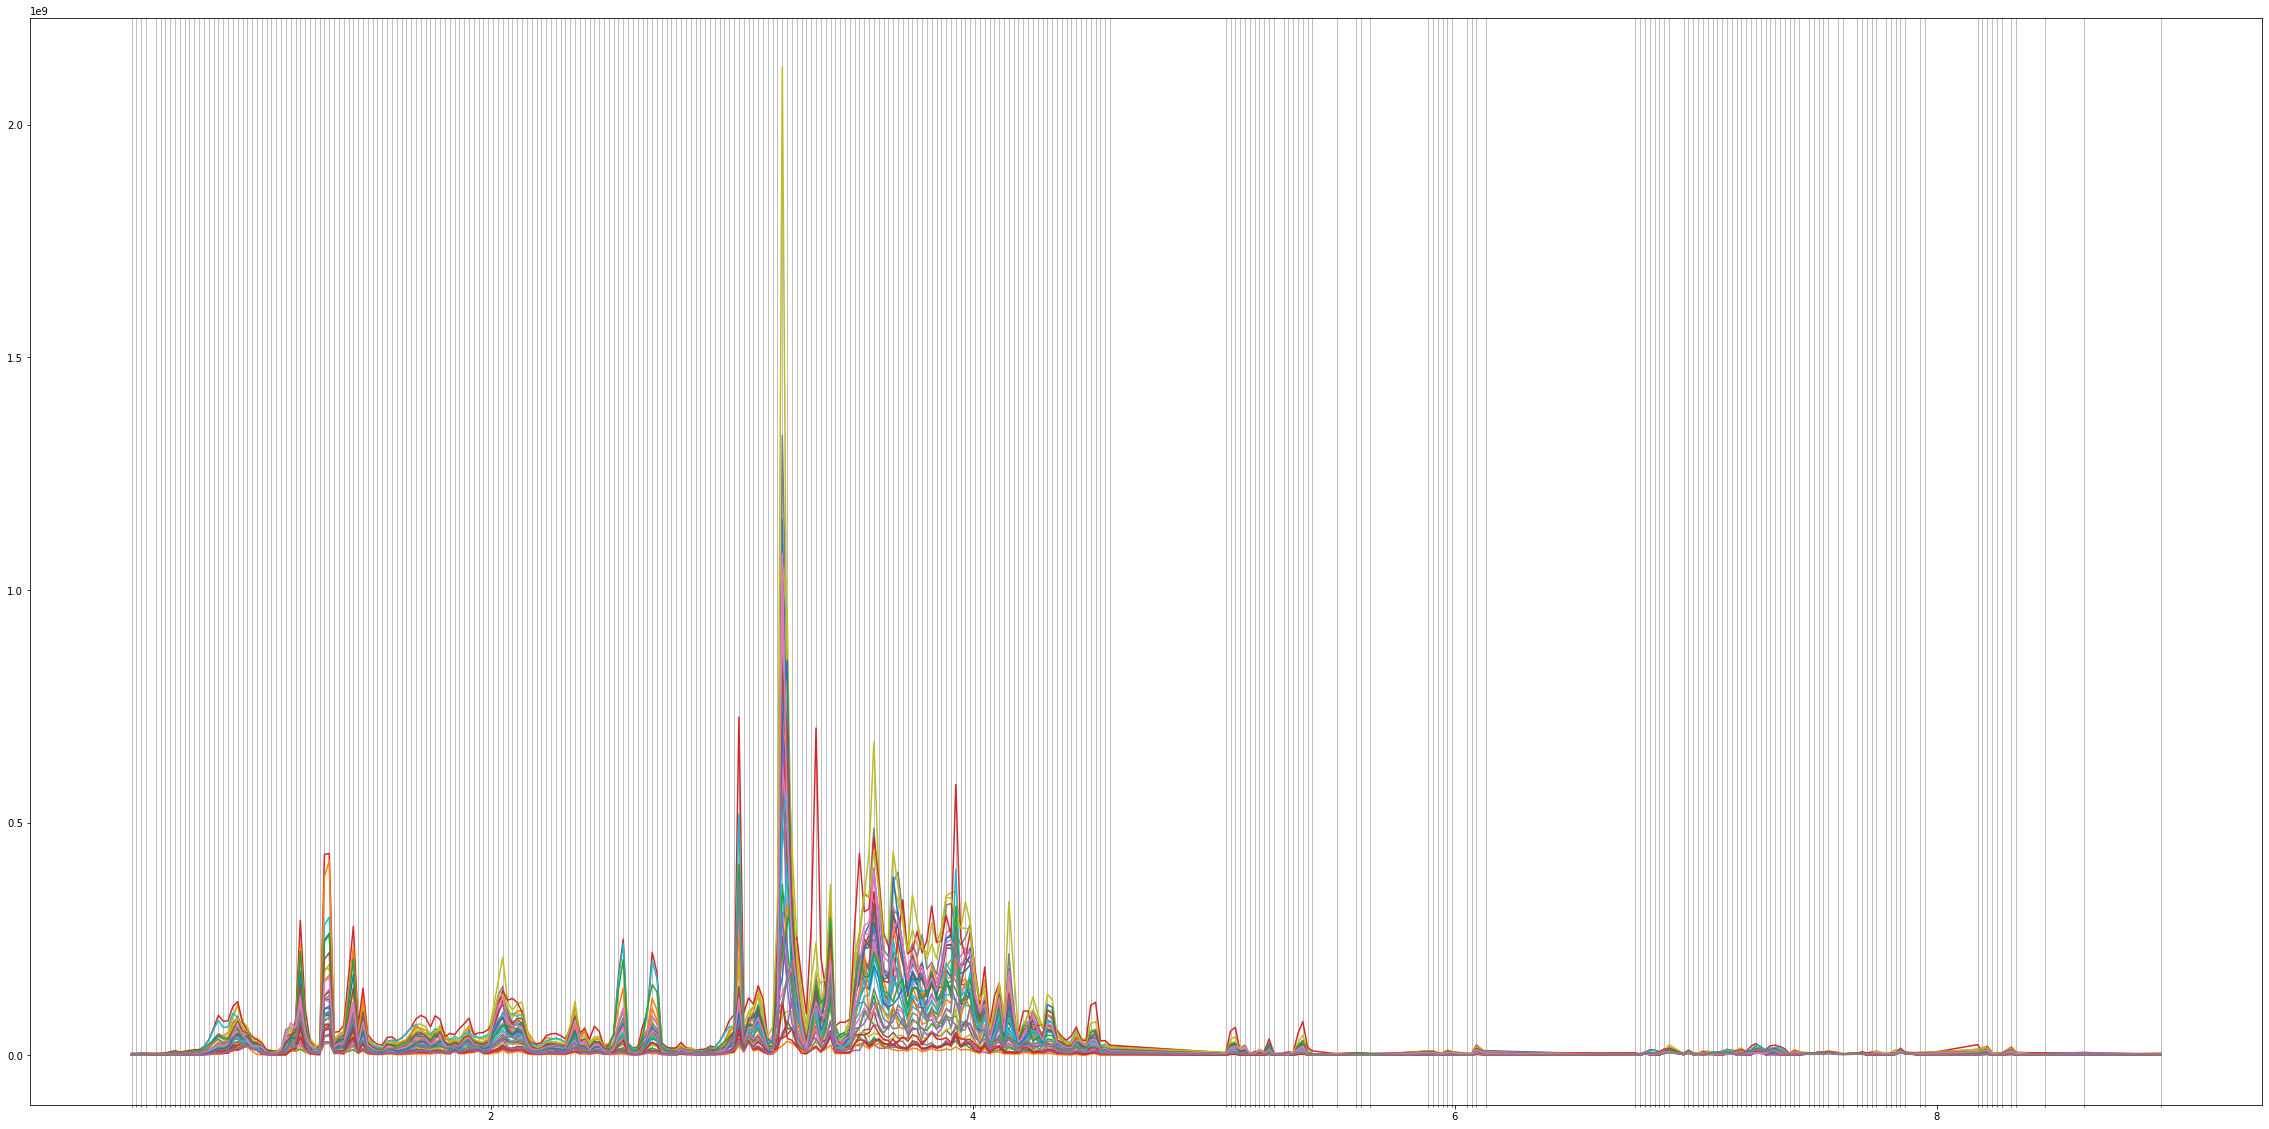

In [8]:
#plot noisefiltered data
ax = data_nf.T.plot(legend= None)
xtick = data_nf.columns
ax.set_xticks( xtick, minor=True )
ax.grid(True, which='minor', axis='x' )
ax.grid(False, which='major', axis='x' )

Normalization of data

In [9]:
#to sample weight
data_weighted = data_nf.div(md['sample weight (mg)'], axis = 0)

#to internal reference
data_noesy = data_weighted.div(ref, axis = 0)

Make PCA score plot with pareto scaled data

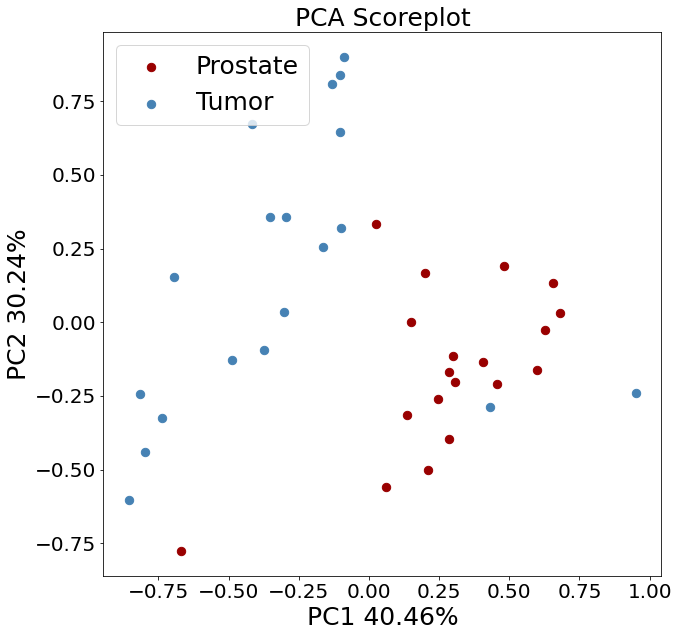

[40.46 30.24  6.67  5.09  4.06  3.08  2.43  2.2   1.16  0.82  0.65  0.49
  0.38  0.35  0.31  0.24  0.18  0.16  0.14  0.13  0.12  0.11  0.09  0.08
  0.07  0.05  0.05  0.04  0.03  0.03  0.02  0.02  0.02  0.01  0.01  0.01
  0.    0.  ]


In [10]:
makepca(data_noesy, md['Tissue'], 'p')

Make RF feature analysis (takes a lon time to run)

Out-of-bag score (%): 89.47368421052632


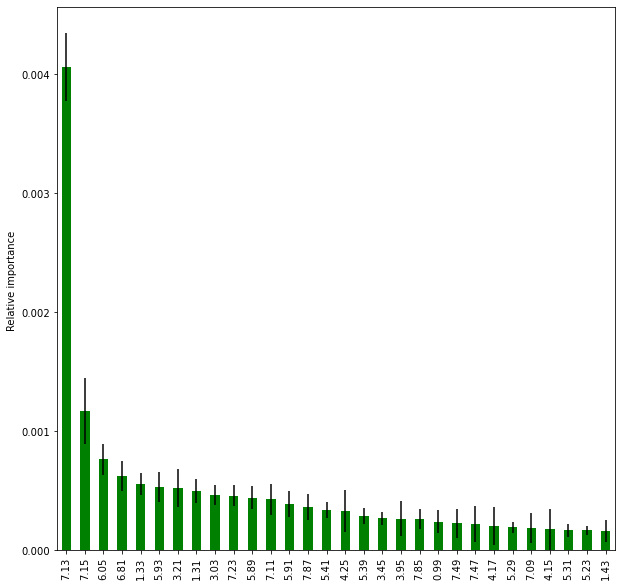

In [11]:
rf_noesy = makerf(data_noesy, md["Tissue"])

Save generated DataFrame with RF results


In [12]:
pickle.dump(rf_noesy, open("imp_chart_noesy.p","wb"))

In [12]:
#rf_noesy = pickle.load(open('imp_chart_noesy.p', 'rb'))

In [13]:
rf_noesy

,Mean,std err.,color
7.13,0.004064,0.000286,g
7.15,0.001170,0.000275,g
6.05,0.000767,0.000130,g
6.81,0.000628,0.000126,g
1.33,0.000558,0.000095,g
...,...,...,...
7.59,-0.000903,0.000157,r
7.27,-0.001001,0.000235,r
6.95,-0.001201,0.000193,r
1.85,-0.001560,0.000177,r


Get significantly important features

In [14]:
imps_noesy = imp_clean(rf_noesy)
len(imps_noesy), imps_noesy

(17,
 array([7.13, 7.15, 6.05, 6.81, 1.33, 5.93, 3.21, 1.31, 3.03, 7.23, 5.89,
        7.11, 5.91, 7.87, 5.41, 5.39, 3.45]))

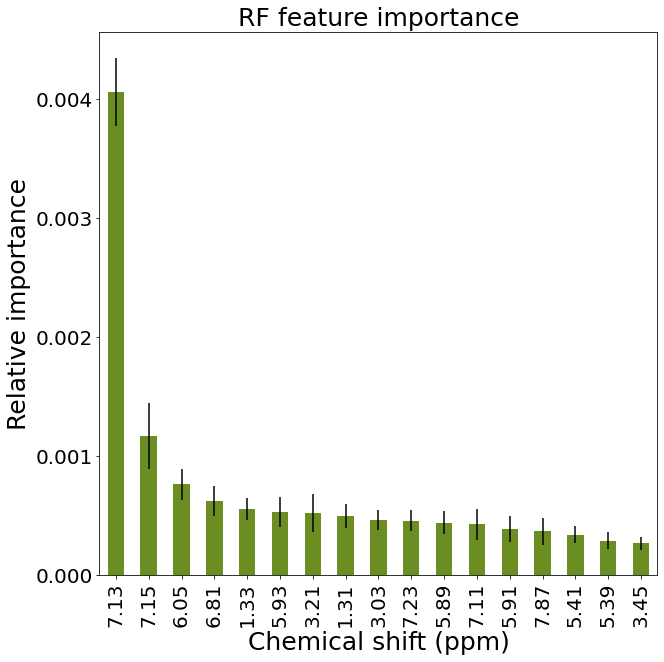

In [15]:
plot_rfs(rf_noesy, imps_noesy)

Make SVM analysis of chosen features

In [16]:
noesy_svm = svm_feats(data_noesy, md["Tissue"], imps_noesy)

Scaling method: Auto-scale


In [17]:
noesy_svm

,score,params
1,0.973684,"{'C': 8.0, 'kernel': 'linear'}"
2,0.947368,"{'C': 0.25, 'kernel': 'linear'}"
3,1.000000,"{'C': 0.25, 'kernel': 'linear'}"
4,1.000000,"{'C': 1.0, 'kernel': 'linear'}"
5,0.973684,"{'C': 0.5, 'kernel': 'linear'}"
6,0.973684,"{'C': 4.0, 'kernel': 'linear'}"
7,0.947368,"{'C': 0.25, 'kernel': 'linear'}"
8,0.947368,"{'C': 0.5, 'kernel': 'linear'}"
9,0.947368,"{'C': 0.5, 'kernel': 'linear'}"
10,0.947368,"{'C': 0.5, 'kernel': 'linear'}"
